# Regression Script
## Partial Least Squares

### Florian Beyer
### 2020-04-28
### V0.2

Quelle:
- https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153
- variable importance: https://github.com/scikit-learn/scikit-learn/issues/7050

In [1]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets
from joblib import dump, load
from operator import itemgetter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [5]:
# data input

# define a number of trees that should be used (default = 500)
est = 1000

# Size of splitting the data (0.1 -> 10 % test data, 90 % training data)
testSize = 0.25

randomState = 35

# the remote sensing image you want to classify
img_RS = 'N:/Projekt_Wetscapes/Bearbeitung/2020_05_15_Wakene_PWPD/Raster/Stack/2018_06_12_PW_FINAL.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'N:/Projekt_Wetscapes/Bearbeitung/2020_05_15_Wakene_PWPD/Vektor/2018_06_12_PW_SOM.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'SOM%'


# save path, predicted image
prediction_map = 'N:/Projekt_Wetscapes/Bearbeitung/2020_05_15_Wakene_PWPD/Ergebnisse/PLSR_PW.tif'


# save path, trained model
#save_model = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_SPAD_PLSR_model.joblib'


In [6]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['Point_ID', 'Hochwert_B', 'Rechtswert', 'Ortho_Heig', 'Datum_Uhrz', 'SOM%']


In [7]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [8]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


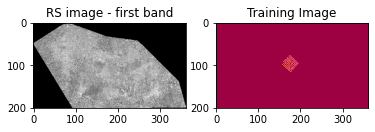

In [9]:
# Display image and Training data

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()


In [10]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))# Subset the image dataset with the training image = X

We have 99 training samples


In [11]:
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

In [12]:
features = pd.DataFrame(X)

band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

features.columns = band_names

print('The shape of our features is:', features.shape)
print('The number of Spectra is:', features.shape[0])
print('The number of bands is:', features.shape[1])

features['value'] = y

features.head()

The shape of our features is: (99, 22)
The number of Spectra is: 99
The number of bands is: 22


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,...,Band_14,Band_15,Band_16,Band_17,Band_18,Band_19,Band_20,Band_21,Band_22,value
0,207.0,195.0,126.0,0.093320,0.060134,0.396954,0.536450,39.932461,17.477051,0.173958,...,0.703638,1.822521,0.737664,0.686452,0.460362,0.149448,0.798404,-0.049983,-0.263094,67
1,135.0,142.0,45.0,0.077374,0.060754,0.349857,0.495003,39.920631,17.362862,0.156310,...,0.729640,1.351004,0.651246,0.620259,0.413810,0.171799,0.781365,-0.037262,-0.105379,68
2,159.0,176.0,85.0,0.096029,0.058483,0.391974,0.510051,39.734531,18.012812,0.188273,...,0.683115,1.838486,0.708831,0.673708,0.450843,0.130903,0.794269,-0.052421,-0.263771,66
3,142.0,140.0,68.0,0.090704,0.069798,0.325486,0.415276,39.648048,17.738144,0.218418,...,0.641473,0.973365,0.530101,0.511192,0.389555,0.121213,0.712217,-0.043958,0.177311,67
4,134.0,156.0,44.0,0.084393,0.040341,0.408180,0.569568,39.812912,17.078974,0.148171,...,0.741901,3.066665,0.830809,0.805375,0.460149,0.165061,0.867715,-0.050934,-1.081276,67


In [13]:
# Labels are the values we want to predict
labels = np.array(features['value'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('value', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = testSize, random_state = randomState)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (74, 22)
Training Labels Shape: (74,)
Testing Features Shape: (25, 22)
Testing Labels Shape: (25,)


In [14]:
plsr = PLSRegression(n_components=4,
                     scale=True,
                     max_iter=500,
                     tol=1e-06,
                     copy=True)

plsr.fit(train_features, train_labels)

PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)

In [15]:
print(plsr.score(train_features, train_labels))

0.1893197168849099


In [16]:
# band importances

# function for variable importance
def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

importance = vip(plsr)


imp = {}
for i in range(features.shape[1]):
    print('Band {}: {}'.format(i+1, importance[i]))
    imp['Band{}'.format(i+1)] = importance[i]

Band 1: 0.888578412215833
Band 2: 0.8401577124279724
Band 3: 1.4006620290258422
Band 4: 1.0196984541338066
Band 5: 1.0609943018042145
Band 6: 0.9458786447184454
Band 7: 0.9007575752660638
Band 8: 1.3031628546422949
Band 9: 1.445970696027381
Band 10: 0.9115136201447281
Band 11: 0.8405468876852087
Band 12: 0.8996895316714049
Band 13: 0.9407342961613152
Band 14: 0.8765004393847825
Band 15: 0.9661322690428629
Band 16: 0.8792624584062956
Band 17: 0.8669363708065428
Band 18: 0.9669615627864948
Band 19: 0.8468630769758615
Band 20: 0.9480435601311479
Band 21: 0.9505763041444075
Band 22: 0.984572180713141


In [17]:
sorted_imp = dict(sorted(imp.items(), key=itemgetter(1), reverse=True))
sorted_imp 

{'Band9': 1.445970696027381,
 'Band3': 1.4006620290258422,
 'Band8': 1.3031628546422949,
 'Band5': 1.0609943018042145,
 'Band4': 1.0196984541338066,
 'Band22': 0.984572180713141,
 'Band18': 0.9669615627864948,
 'Band15': 0.9661322690428629,
 'Band21': 0.9505763041444075,
 'Band20': 0.9480435601311479,
 'Band6': 0.9458786447184454,
 'Band13': 0.9407342961613152,
 'Band10': 0.9115136201447281,
 'Band7': 0.9007575752660638,
 'Band12': 0.8996895316714049,
 'Band1': 0.888578412215833,
 'Band16': 0.8792624584062956,
 'Band14': 0.8765004393847825,
 'Band17': 0.8669363708065428,
 'Band19': 0.8468630769758615,
 'Band11': 0.8405468876852087,
 'Band2': 0.8401577124279724}

In [19]:
# predict test data
predictions_test_ds = plsr.predict(test_features)


In [20]:
# Calculate the absolute errors
errors = abs(predictions_test_ds - test_labels)
# Print out the mean absolute error (mae)

# Print out the mean absolute error (mae)


print('-------------')
print('n of the test data: {}'.format(len(test_labels)))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)))
print('-------------')
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)))

mse = mean_squared_error(test_labels, predictions_test_ds)
print('Mean squared error: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(np.sqrt(mse)))

'''
To put our predictions in perspective, we can calculate an accuracy using
the mean average percentage error subtracted from 100 %.
'''

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('mean absolute percentage error (MAPE) / Accuracy: {:.2f}'.format(accuracy), '%.')
print('-------------')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(test_labels, predictions_test_ds)))



-------------
n of the test data: 25
Mean of the variable: 72.99
Standard deviation of the variable: 3.83
-------------
Mean Absolute Error: 3.44
Mean squared error: 12.34
RMSE: 3.51
mean absolute percentage error (MAPE) / Accuracy: 95.33 %.
-------------
Coefficient of determination r²: 0.04


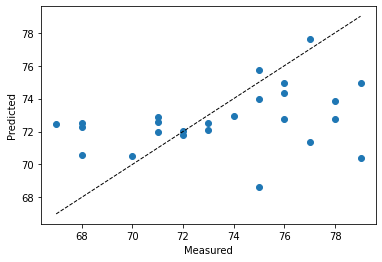

In [21]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions_test_ds)
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

In [22]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (201, 361, 22) to (72561, 22)


In [23]:
prediction_ = plsr.predict(img_as_array)

In [24]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (201, 361)


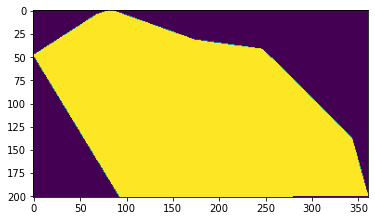

In [25]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

In [23]:
# mask classification an plot


prediction = prediction*mask



In [25]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

prediction.astype(np.float32)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: N:\Daten_GG\projekte\PFIFFikus (EFRE) - 74120125\Bilder\2020_06_05_Bliesekow_EP1\GIS\Ergebnis\B1W_SPAD_PLSR.tif


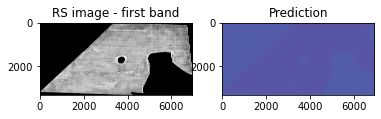

In [25]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(prediction, cmap=plt.cm.Spectral)
plt.title('Prediction')

plt.show()

In [26]:
pla = 0.0599 * np.exp(0.0493*prediction)
pla = pla*mask


pla_path = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_PLA_PLSR.tif'

In [27]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(pla_path, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(pla)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(pla_path))


Image saved to: N:\Daten_GG\projekte\PFIFFikus (EFRE) - 74120125\Bilder\2020_06_05_Bliesekow_EP1\GIS\Ergebnis\B1W_PLA_PLSR.tif


In [28]:
lfw = 0.305 * np.exp(0.0545*prediction)
lfw = lfw*mask

lfw_path = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_LFW_PLSR.tif'

In [29]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(lfw_path, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(lfw)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(lfw_path))

Image saved to: N:\Daten_GG\projekte\PFIFFikus (EFRE) - 74120125\Bilder\2020_06_05_Bliesekow_EP1\GIS\Ergebnis\B1W_LFW_PLSR.tif


In [33]:
testi= 30



print('BSNC_richtig: {}'.format(1669.54-1.72117*np.sqrt(3.14696*10**6 - 58100*testi)))



print('PNC richtig: {}'.format(4.00987-0.000266738*np.sqrt(2.38385*10**8-3.749*10**6*testi)))


print('PNA richtig: {}'.format(1.81599*np.exp(0.0702494*testi)))

BSNC_richtig: -369.85398942157417
PNC richtig: 1.016753469944871
PNA richtig: 14.94105470936657


In [24]:
bsnc = 1669.54-1.72117*np.sqrt(3.14696*10**6 - 58100*prediction)
bsnc = bsnc*mask

bsnc_path = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_BSNC_PLSR.tif'

<ipython-input-24-200cac87e096>:1: RuntimeWarning: invalid value encountered in sqrt
  bsnc = 1669.54-1.72117*np.sqrt(3.14696*10**6 - 58100*prediction)


In [25]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(bsnc_path, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(bsnc)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(bsnc_path))

Image saved to: N:\Daten_GG\projekte\PFIFFikus (EFRE) - 74120125\Bilder\2020_06_05_Bliesekow_EP1\GIS\Ergebnis\B1W_BSNC_PLSR.tif


In [26]:
pnc = 4.00987-0.000266738*np.sqrt(2.38385*10**8-3.749*10**6*prediction)
pnc = pnc*mask

pnc_path = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_PNC_PLSR.tif'

<ipython-input-26-fdafdfa944f3>:1: RuntimeWarning: invalid value encountered in sqrt
  pnc = 4.00987-0.000266738*np.sqrt(2.38385*10**8-3.749*10**6*prediction)


In [30]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(pnc_path, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(pnc)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(pnc_path))

Image saved to: N:\Daten_GG\projekte\PFIFFikus (EFRE) - 74120125\Bilder\2020_06_05_Bliesekow_EP1\GIS\Ergebnis\B1W_PNC_PLSR.tif


In [ ]:
1.81599*np.exp(0.0702494*testi)

In [28]:
pna = 4.00987-0.000266738*np.sqrt(2.38385*10**8-3.749*10**6*prediction)
pna = pna*mask

pna_path = 'N:\\Daten_GG\\projekte\\PFIFFikus (EFRE) - 74120125\\Bilder\\2020_06_05_Bliesekow_EP1\\GIS\\Ergebnis\\B1W_PNA_PLSR.tif'

<ipython-input-28-2870334f7153>:1: RuntimeWarning: invalid value encountered in sqrt
  pna = 4.00987-0.000266738*np.sqrt(2.38385*10**8-3.749*10**6*prediction)


In [29]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(pna_path, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(pna)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(pna_path))

Image saved to: N:\Daten_GG\projekte\PFIFFikus (EFRE) - 74120125\Bilder\2020_06_05_Bliesekow_EP1\GIS\Ergebnis\B1W_PNA_PLSR.tif
